## Load JEPA model and sample data

In [2]:
import sys
sys.path.append('/home/rafik/Documents/InnoUni/ai_lab/Sym-JEPA')

In [39]:
from model import SymJEPA


jepa = SymJEPA(tokenization='octuple', pass_target_mask_to_predictor=True).cuda()

pe add global time
pe add modulo time
pe add idx


In [46]:
import torch

ckpt_path = '/home/rafik/attn-masks.ckpt'

ckpt_path = '/home/rafik/epoch=0-step=76176.ckpt'

jepa.load_state_dict(torch.load(ckpt_path)['state_dict'])

<All keys matched successfully>

In [5]:
import os
from glob import glob

midi_files = glob(os.path.join("/home/rafik/Documents/InnoUni/ai_lab/Sym-JEPA/dataset/clean_midi/", "**/*.mid"), recursive=True)[:100]

print([os.path.basename(f) for f in midi_files])

['If I Said You Had a Beautiful Body (Would You Hold It Against Me).mid', 'I Need More of You.mid', 'Let Your Love Flow.1.mid', 'Let Your Love Flow.mid', 'Crossfire.mid', 'On a Summer Night.mid', 'Rode schoentjes.mid', 'Sacramento.mid', 'Chirpy Chirpy Cheep Cheep.1.mid', 'Chirpy Chirpy Cheep Cheep.mid', 'Sacramento.1.mid', 'Freestyler.mid', 'Little Girl.mid', 'Tangerine.mid', 'Come Rain or Come Shine.mid', 'Who Can It Be Now.mid', 'Who Can It Be Now.1.mid', 'Down Under.mid', 'Down Under.1.mid', 'Nocturne for piano No. 8 (9) in E minor, H46b.mid', 'Nocturne in F: No.6 H40.mid', 'Santa Monica.1.mid', 'Santa Monica.mid', 'I Will Buy You a New Life.mid', 'Everything to Everyone.mid', 'Father of Mine.mid', "I'm Telling You Now.mid", "I'm Tellin' You Now.mid", 'Diego, libre dans sa tete.mid', 'Everything I Own.mid', 'Tobacco Road.mid', 'Murmullo.mid', 'El cuarto de Tula.mid', 'Candela.mid', 'Treat Her Like a Lady.mid', "It's Too Late to Turn Back Now.mid", "Stumblin' In.mid", "If You Can't G

In [ ]:
from dataset import MidiDataset
from octuple_tokenizer import OctupleTokenizer

dataset = MidiDataset(midi_files, max_len=2048, tokenization='octuple', group_bars=True, max_bars=512, max_positions=512, max_bars_per_context=-1, max_contexts_per_file=-1, bar_token_mask=None, bar_token_idx=2, use_cache=True, print_errors=False, tokenizer_class=OctupleTokenizer, use_mask_padding=False, genre_map_path='../metadata/midi_genre_map.json', skip_unknown_genres=False, skip_unknown_styles=False, sample_count_per_sequence=1)

print(len(dataset))



100%|██████████| 100/100 [00:05<00:00, 20.00it/s]

2254


In [7]:
import numpy as np

print(np.version.version)

1.26.0


## Calculate embedding vectors

In [50]:
from tqdm import tqdm

vectors = []

n = 100
jepa.eval()
for i in tqdm(range(n)):
    with torch.no_grad():
        vectors.append(jepa.encode_context(dataset[i]['input_ids'].cuda().unsqueeze(0)))


print(vectors[0].shape)



100%|██████████| 100/100 [00:02<00:00, 42.31it/s]

torch.Size([1, 256, 512])


## Statistics of the embedding vectors

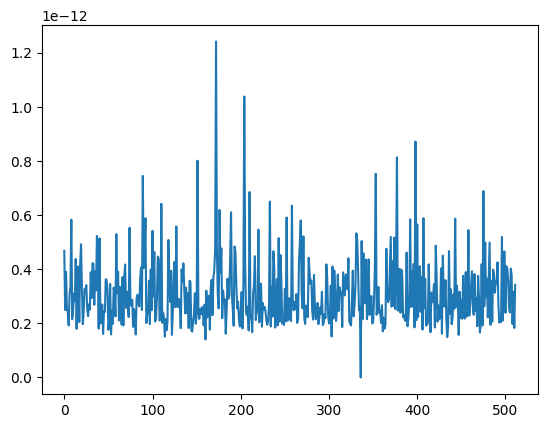

In [51]:
import matplotlib.pyplot as plt

# print(torch.stack(vectors).shape)
# Calculate the mean of the vectors
mean_vector = torch.mean(torch.stack(vectors), dim=0)


# Variance per dimension
variances = torch.var(torch.stack(vectors).view(-1, 512), dim=0)

# Plot variance per dimension
plt.plot(variances.cpu().numpy())
plt.show()


torch.Size([25600, 512])
Some vector norms:
tensor(7.6300, device='cuda:0')
tensor(7.6300, device='cuda:0')
tensor(7.6300, device='cuda:0')


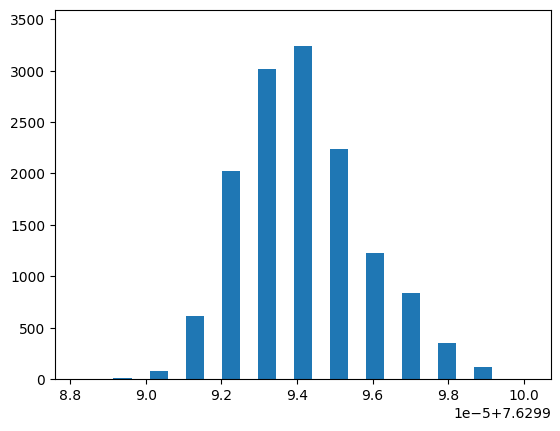

In [52]:
all_vectors = torch.stack(vectors).squeeze(0).reshape(-1, 512)

print(all_vectors.shape)
# Distribution of vector norms
norms = torch.norm(all_vectors, dim=1)

print("Some vector norms:")
print(norms[0])
print(norms[1])
print(norms[-1])

plt.hist(norms.cpu().numpy(), bins=100)
plt.show()



tensor(1., device='cuda:0')


Percentage of similarities greater than 0.9:
100.0 %


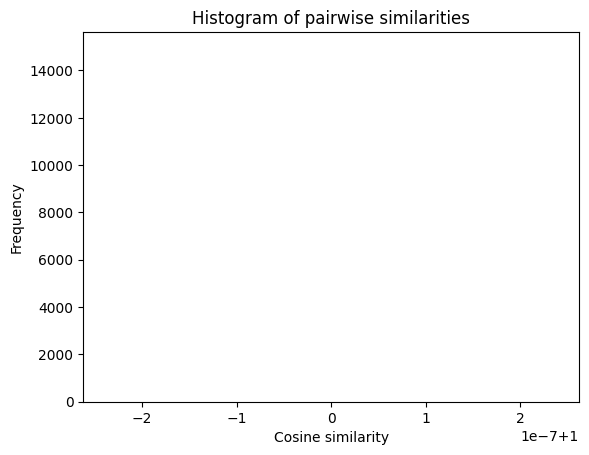

In [57]:
# Histogram of pairwise similarities

similarities = torch.nn.functional.cosine_similarity(all_vectors, all_vectors, dim=1)

print(similarities[0])

print("\n\nPercentage of similarities greater than 0.9:")
print(100 * torch.sum(similarities > 0.9).item() / len(similarities), "%")

plt.hist(similarities.cpu().numpy(), bins=100)
plt.title("Histogram of pairwise similarities")
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.show()




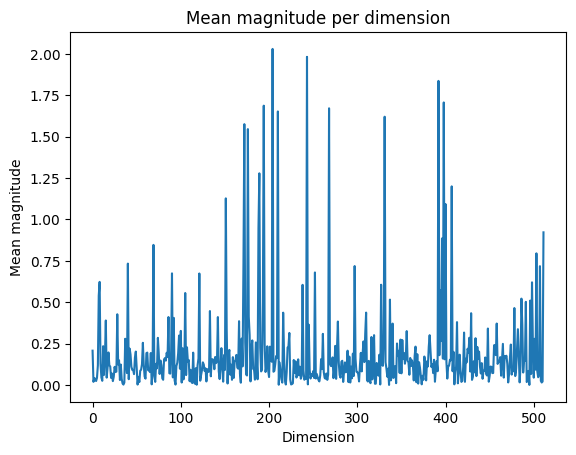

In [58]:
# Plot mean magnitude per dimension
mean_magnitude = torch.mean(torch.abs(all_vectors), dim=0)

plt.plot(mean_magnitude.cpu().numpy())
plt.title("Mean magnitude per dimension")
plt.xlabel("Dimension")
plt.ylabel("Mean magnitude")
plt.show()